<a href="https://colab.research.google.com/github/ReymoT/background-generator/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.


## 1. Problem

Identifying the breed of a dog given an image of a dog.

## 2. Data

The data we're using is from Kaggle dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/overview

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set (no labels, because we want to predict them)

In [ ]:
# Unzip the uploaded data into Google Drive
#!unzip "drive/My Drive/Machine Learning/dog-breed-identification.zip" -d "drive/My Drive/Machine Learning/"

### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're  using a GPU

In [ ]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF Version:", tf.__version__)
print("TF Hub Version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YES)" if tf.config.list_physical_devices("GPU") else "not available")

TF Version: 2.2.0
TF Hub Version: 0.8.0
GPU available (YES)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. We'll be turning our data into tensors (numerical representation)

Let's access our data and check out the labels.

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Machine Learning/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     acf27cad5544fbed6baa345666f87700  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


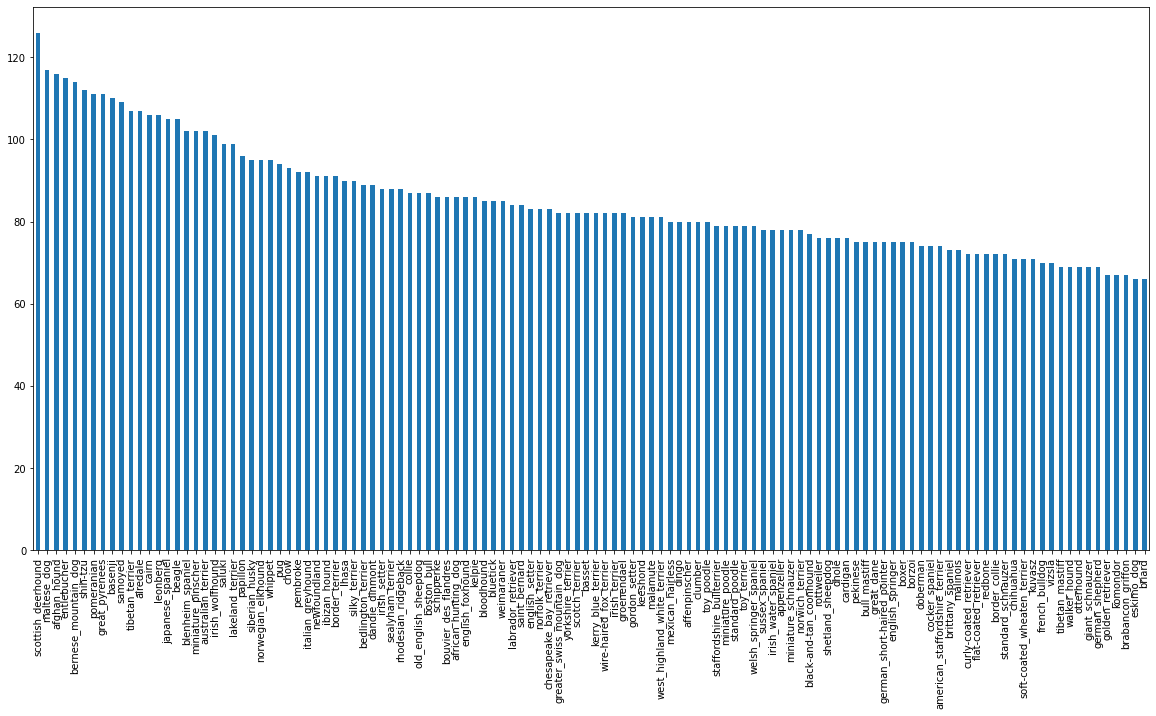

In [ ]:
# How many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

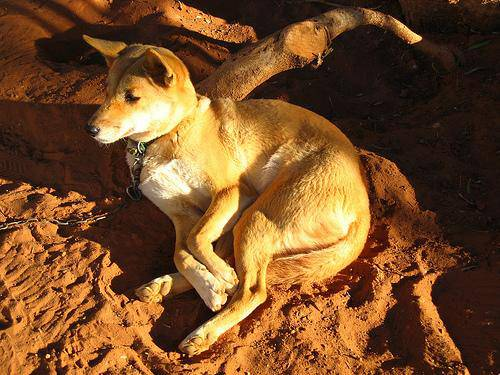

In [ ]:
# View an image
from IPython.display import Image
Image("drive/My Drive/Machine Learning/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Get images and their labels

Get a list of all of out image file pathnames

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Machine Learning/train/"+ fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/My Drive/Machine Learning/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Machine Learning/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Machine Learning/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Machine Learning/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Machine Learning/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Machine Learning/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Machine Learning/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Machine Learning/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Machine Learning/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Machine Learning/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Machine Learning/train/")) == len(filenames):
  print("Filenames match actual amount of files, proceed")
else:
  print("Filenames do not match actual number of files, check the target directory")

Filenames match actual amount of files, proceed


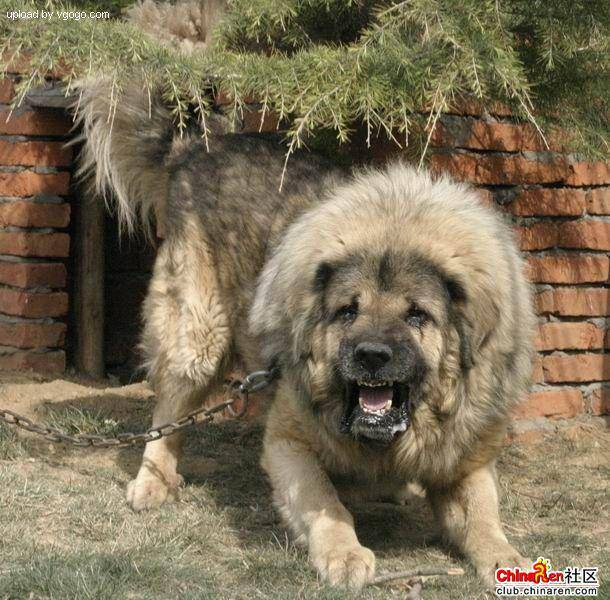

In [ ]:
# One more check
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Training image filepaths are in a list, let's prepare our labels:

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # does the same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("number of labels does not match number of filenames, check data directories")

Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
The Kaggle dataset doesn't come with a validation set, so we're going to create our own validation set.

In [ ]:
# Setup X and y variables
X = filenames
y = boolean_labels

We're gonna start off experimenting with about 1000 images and increase along the way

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000, step:1000}

In [ ]:
# Splitting our data into train and validation
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
#Training data
X_train[:5], y_train[:2]

(['drive/My Drive/Machine Learning/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Machine Learning/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Machine Learning/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Machine Learning/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Machine Learning/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, 

## Preprocessing Images (turning images into Tensors)

To turn our images into Tensors, we're going to write a function that does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

Before writing the function let's see what an image looks like

In [ ]:
# Convert an image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
# Turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

We've seen what an image looks like as a Tensor
Let's write the function

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn jpeg image into a numerical Tensor with 3 color channels (red, green and blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0 to 255 to 0-1 values (for efficient computing)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn data into batches?

Let's say you're trying to process 10,000+ images in one attempt, they might not fit into memory.

We're going to set the batch size to 32 (can be manually adjusted, if needed)

To use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`

In [ ]:
# Create a simple function to return a tuple of Tensors
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label, processes the image and returns the tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Demo of the above
(process_image(X[42]), tf.constant((y[42])))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

We've got a way to turn our data into tuples of Tensors in the form: `(image, label)`,
write a function to turn all of our data (`X` & `y`) into batches.

In [ ]:
# Define the batch size, 32 is a great start
BATCH_SIZE = 32

# Create function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths, no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a validation dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepaths
                                                 tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                 tf.constant(y)))
    # Shuffle pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size = len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch


In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them.

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 to display 25 images
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [ ]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Because train_data is a batch, we need to turn it into an iterator
#train_images, train_labels = next(train_data.as_numpy_iterator())

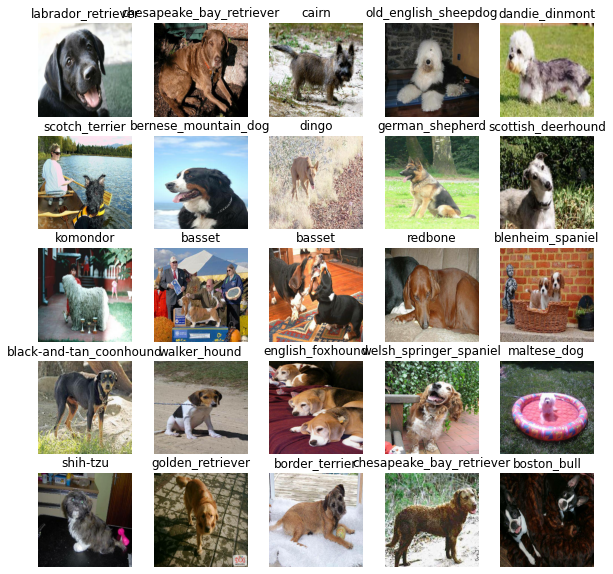

In [ ]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

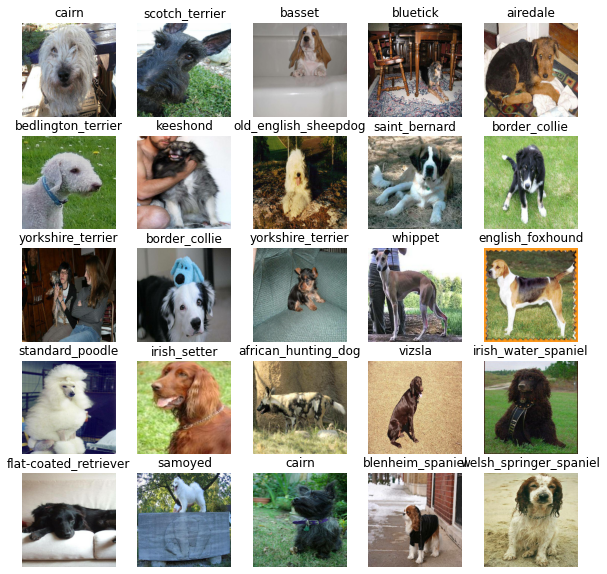

In [ ]:
# Now let's visualize validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define
* The input shape (images shape, in the form of Tensors) to our model
* The output shape (image labels, in the form of Tensors) of our model
* The URL of the model we want to use from TensorFlow Hub https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Inputs, outputs and model are ready to go. Let's use a Keras deep learning model.

Write a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improves).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here https://www.tensorflow.org/guide/keras/overview

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1, input layer
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2, output layer
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [ ]:
outputs = np.ones(shape=(1, 2, 1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])

## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop learning early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard callback

To setup a TensorBoard callback we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our models `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (after model training)

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Machine Learning/logs",
                        # Make it so the logs get tracked everytime we run an experiment
                        datetime.datetime.now().strftime("Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

## Early Stopping Callback

Early stopping helps stop out model from overfitting by stopping training when a certain evaluation metric stops improving.

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (subset of data)

Our first model is going to train on 1000 images to make sure everything is working.



In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we're still running on a GPU
print("GPU", "available (YES)" if tf.config.list_physical_devices("GPU") else "not available")

GPU available (YES)


Create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use.
* Return the model

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session every time we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])

  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 510s 20s/step - loss: 4.6818 - accuracy: 0.0962 - val_loss: 3.5197 - val_accuracy: 0.2300
Epoch 2/100
25/25 [==============================] - 6s 254ms/step - loss: 1.6662 - accuracy: 0.6900 - val_loss: 2.2310 - val_accuracy: 0.5000
Epoch 3/100
25/25 [==============================] - 6s 252ms/step - loss: 0.5800 - accuracy: 0.9337 - val_loss: 1.6915 - val_accuracy: 0.5850
Epoch 4/100
25/25 [==============================] - 6s 253ms/step - loss: 0.2569 - accuracy: 0.9862 - val_loss: 1.4987 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 6s 257ms/step - loss: 0.1499 - accuracy: 0.9962 - val_loss: 1.4234 - val_accuracy: 0.6500
Epoch 6/100
25/25 [==============================] - 6s 256ms/step - loss: 0.1021 - accuracy: 1.0000 - val_loss: 1.3665 - val_accuracy: 0.6500
Epoch 7/100
25/25 [==============================

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing, it means our model is learning.

### Checking the TensorBoard logs

The TensorBoard magic function `%tensorboard` will access the logs directory we created earlier and visualize its contents.

In [ ]:
%tensorboard --logdir drive/My\ Drive/Machine\ Learning/logs

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 189ms/step


array([[0.00442797, 0.00783321, 0.00241084, ..., 0.0319358 , 0.00155576,
        0.00147761],
       [0.00483223, 0.01635489, 0.01340333, ..., 0.00780385, 0.00768263,
        0.00904065],
       [0.00211238, 0.00041722, 0.00518618, ..., 0.01728016, 0.02049604,
        0.00047186],
       ...,
       [0.0016905 , 0.00959078, 0.00486143, ..., 0.00312316, 0.00210597,
        0.00635346],
       [0.00114169, 0.00259534, 0.00890443, ..., 0.00882902, 0.00257938,
        0.00739978],
       [0.01236554, 0.00654474, 0.04855131, ..., 0.00539771, 0.0001558 ,
        0.00178423]], dtype=float32)

In [ ]:
# First prediction
index = 42
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[0.00442797 0.00783321 0.00241084 0.02460264 0.00543973 0.00029861
 0.02053515 0.00359894 0.00199221 0.01891888 0.00283586 0.00502141
 0.00896965 0.00343748 0.05970774 0.00065059 0.00938617 0.00050438
 0.0114743  0.02286967 0.00969959 0.00478068 0.00313253 0.00321848
 0.00226191 0.00427628 0.0003369  0.00048497 0.02088244 0.00959401
 0.00630051 0.00535159 0.06606641 0.0100704  0.04533505 0.0093789
 0.0084999  0.00358928 0.00063068 0.00746529 0.00489812 0.00530591
 0.0009     0.03225165 0.00529364 0.00144868 0.00184749 0.0080165
 0.00062146 0.00047514 0.00592292 0.00350567 0.04618099 0.00332451
 0.00131055 0.01104276 0.00956334 0.00387014 0.00729839 0.00104825
 0.00144674 0.00469623 0.00161024 0.00906473 0.03779013 0.03292286
 0.00573977 0.00055638 0.00354035 0.00082823 0.00037078 0.00330589
 0.00137765 0.00783304 0.00863549 0.00061036 0.00034132 0.00399024
 0.00127625 0.01892309 0.042174   0.0041338  0.00356445 0.01962987
 0.0125336  0.01881911 0.00118827 0.00070669 0.00105075 0.005760

In [ ]:
unique_breeds[113]

'walker_hound'

Having the above functionality is great, but we want to be able to do it at scale.

It would be even better if we could see the image the prediction is being made on.

**Note:** Prediction probabilities are also known as confidence levels

In [ ]:
# Turn prediction probabilities into their respective label
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'chihuahua'

Since our validation data is still in a batch dataset, we'll have to unbatch it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [ ]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels
  """
  images_ = []
  labels_ = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(unique_breeds[np.argmax(label)])

  return images_, labels_

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make a function to make these all more visual.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth label and an array of images and an integer
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get teh pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label  == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label, np.max(pred_prob) * 100, true_label), color=color)


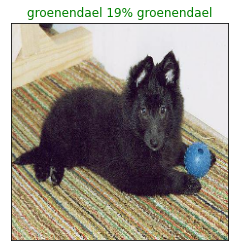

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another one to view our models top 10 predictions.

The function will:
* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the predicted label using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest prediction confidences along with te truth label for sample n
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
                       labels=top_10_pred_labels,
                       rotation="vertical")

  # Change color of true labels
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

In [ ]:
predictions[0].argsort()[-10:][::-1]

array([ 32,  14,  52,  34,  80,  64,  65,  43, 117,   3])

In [ ]:
predictions[0].max()

0.066066414

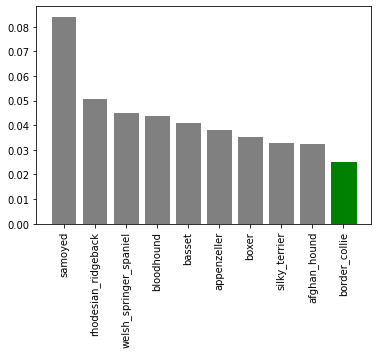

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some functions to help us visualize our predictions and evaluate our model

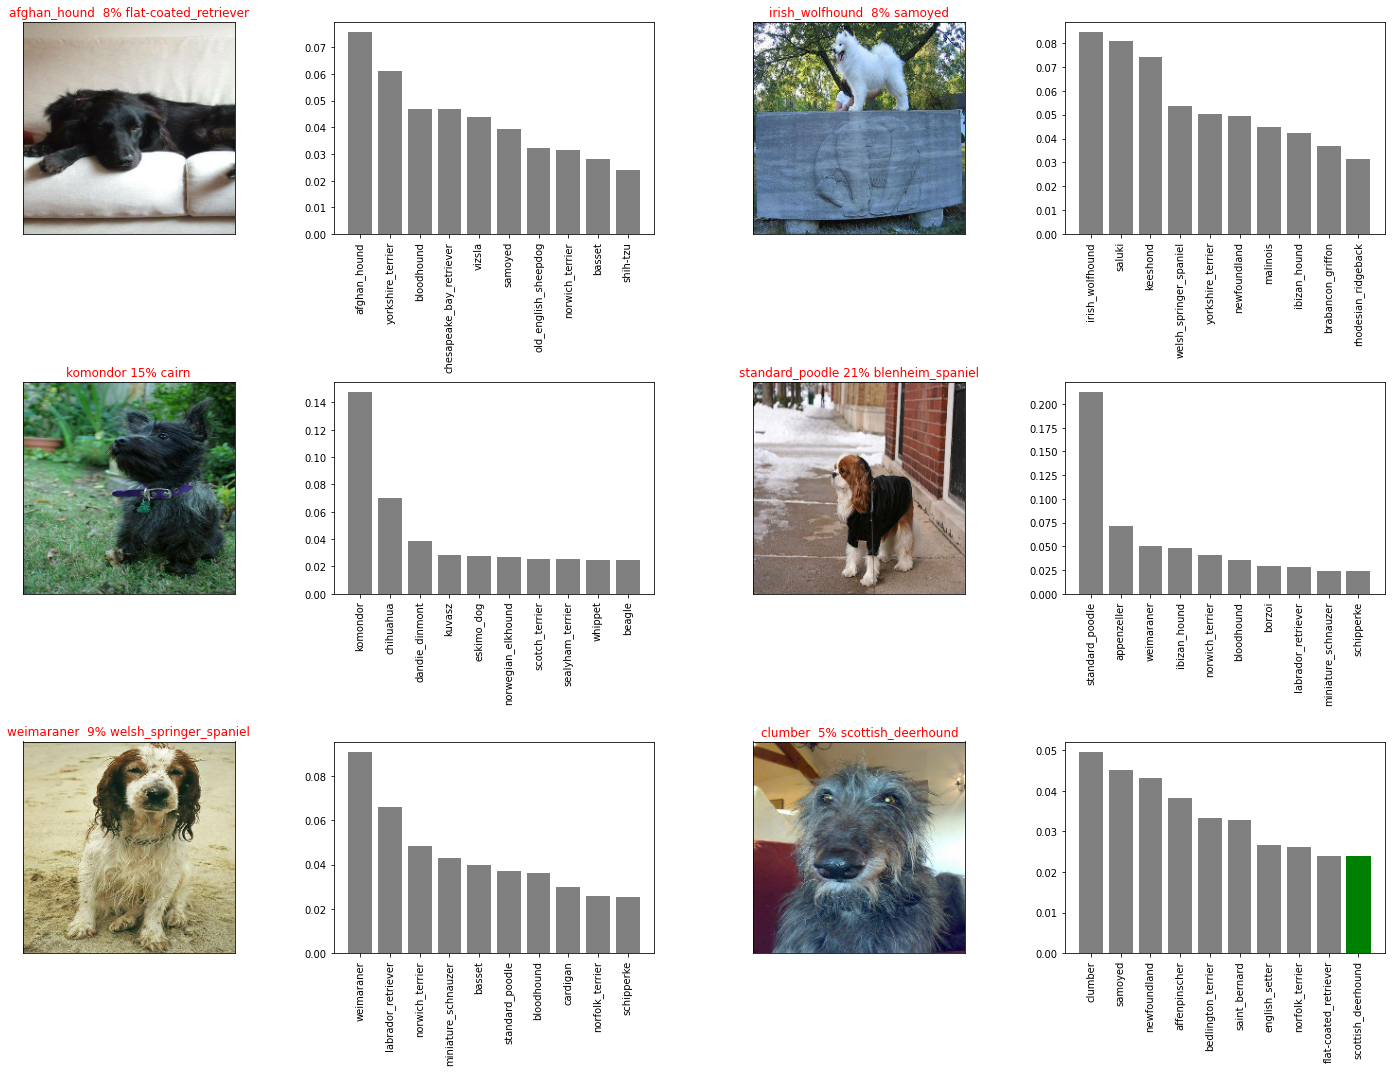

In [ ]:
# Check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge:** How would you create a confusion matrix with our models predictions and true labels?

## Saving and reloading a trained model



In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (strings)
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Machine Learning/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # Save format of a model
  print(f"Saving model to {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from {model_path}...")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
  return model

We've got functions to save and load a trained model, let's test them out

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to drive/My Drive/Machine Learning/models/20200703-07571593763078-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Machine Learning/models/20200703-07571593763078-1000-images-mobilenetv2-Adam.h5'

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model("drive/My Drive/Machine Learning/models/20200701-18291593628163-1000-images-mobilenetv2-Adam.h5")

Loading saved model from drive/My Drive/Machine Learning/models/20200701-18291593628163-1000-images-mobilenetv2-Adam.h5...


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 143ms/step - loss: 5.5544 - accuracy: 0.0200


[5.554391860961914, 0.019999999552965164]

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 151ms/step - loss: 1.1980 - accuracy: 0.6950


[1.1980128288269043, 0.6949999928474426]

## Training a model on the full data

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
X[:10]

['drive/My Drive/Machine Learning/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Machine Learning/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Machine Learning/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Machine Learning/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Machine Learning/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Machine Learning/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Machine Learning/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Machine Learning/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Machine Learning/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Machine Learning/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
len(X_train)

800

In [ ]:
y[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while (maybe 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images to memory.

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to drive/My Drive/Machine Learning/models/20200701-20511593636690-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Machine Learning/models/20200701-20511593636690-full-image-set-mobilenetv2-Adam.h5'

In [ ]:
loaded_full_model = load_model("drive/My Drive/Machine Learning/models/20200701-20511593636690-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from drive/My Drive/Machine Learning/models/20200701-20511593636690-full-image-set-mobilenetv2-Adam.h5...


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we create `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test data` parameter to `True` (since the test data doesn't have labels)
* Make a predictions array by passing the test batches to the `predict()` method called on our model.

In [ ]:
# Load test image filenames
test_path = "drive/My Drive/Machine Learning/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Machine Learning/test/eee7c863af47e22f285f8aeb80adb4b9.jpg',
 'drive/My Drive/Machine Learning/test/f56b4140707da82fe91cb9e5df4ce68c.jpg',
 'drive/My Drive/Machine Learning/test/ed3d8126013933f566dc4113efe7c0bc.jpg',
 'drive/My Drive/Machine Learning/test/ed1d8dfbebbb70b252cd71e165ea3d76.jpg',
 'drive/My Drive/Machine Learning/test/f0ee3d22666302ec27338aa29f34c72f.jpg',
 'drive/My Drive/Machine Learning/test/ed9bab128c26470e18631cb6f3454c99.jpg',
 'drive/My Drive/Machine Learning/test/ea369808f5d3c8fef21c674b80564e35.jpg',
 'drive/My Drive/Machine Learning/test/ef5c93599bcc330fd9642266d9650309.jpg',
 'drive/My Drive/Machine Learning/test/f3df185234b2be78825de1ba63d6c554.jpg',
 'drive/My Drive/Machine Learning/test/f14547a7bed40d4170bc70eafd1eb5e7.jpg']

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on a full model and passing it the test data batch will take a long time to run (about 1h).

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

In [ ]:
# Save predictions (NumPy array) to csv file (access later)
np.savetxt("drive/My Drive/Machine Learning/preds_array.csv", test_predictions, delimiter=",")

In [ ]:
test_predictions = np.loadtxt("drive/My Drive/Machine Learning/preds_array.csv", delimiter=",")

In [ ]:
test_predictions[:10]

array([[4.82378352e-13, 3.43111168e-07, 7.92283828e-13, ...,
        5.04363749e-13, 2.69970215e-08, 1.38417255e-11],
       [7.87415532e-12, 2.02410491e-10, 3.39060746e-12, ...,
        6.91749213e-10, 2.24595733e-13, 2.86892024e-14],
       [2.02747585e-15, 1.68931223e-11, 9.44563074e-16, ...,
        4.38997380e-11, 5.59659803e-08, 7.64258275e-12],
       ...,
       [1.44280213e-11, 2.98108552e-11, 1.95475190e-12, ...,
        5.85153259e-10, 1.85563529e-08, 1.29875537e-11],
       [7.20300051e-08, 5.53776033e-07, 2.20528804e-08, ...,
        4.23350713e-07, 1.99542916e-09, 8.56408406e-06],
       [1.73416677e-08, 1.10556130e-07, 2.02543711e-11, ...,
        6.60297428e-10, 7.32029671e-13, 4.61193826e-11]])

In [ ]:
test_predictions.shape

(10357, 120)

 ## Preparing test dataset predictions for Kaggle

 Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an id column and a column for each different dog breed.

 To get data in this format:
 * Create a pandas DataFrame with an id column as well as a column for each dog breed
 * Add data to the id column by extracting the test image id's from their filepaths
 * Add data (the prediction probabilities) to each of the dog breed columns
 * Export the DataFrame as a csv to submit it to Kaggle.

In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [ ]:
# Append test image id's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

id  ... yorkshire_terrier
0  eee7c863af47e22f285f8aeb80adb4b9  ...               NaN
1  f56b4140707da82fe91cb9e5df4ce68c  ...               NaN
2  ed3d8126013933f566dc4113efe7c0bc  ...               NaN
3  ed1d8dfbebbb70b252cd71e165ea3d76  ...               NaN
4  f0ee3d22666302ec27338aa29f34c72f  ...               NaN

[5 rows x 121 columns]

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  eee7c863af47e22f285f8aeb80adb4b9  ...       1.38417e-11
1  f56b4140707da82fe91cb9e5df4ce68c  ...       2.86892e-14
2  ed3d8126013933f566dc4113efe7c0bc  ...       7.64258e-12
3  ed1d8dfbebbb70b252cd71e165ea3d76  ...       2.22679e-10
4  f0ee3d22666302ec27338aa29f34c72f  ...       1.43768e-09

[5 rows x 121 columns]

In [ ]:
# Save our predictions dataframe to csv for submission to Kaggle
preds_df.to_csv("drive/My Drive/Machine Learning/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

To make predictions on custom images we'll:
* Get the filepaths of our own images
* Turn the filepaths into data batches using `create_data_batches()` and since our custom images won't have labels, we set the `test_data` parameter to `True`
* Pass the custom image data batch to our models `predict()` method
* Convert the prediction output probabilities to prediction labels
* Compare the predicted labels to the custom images

In [ ]:
# Get the custom image filepaths
custom_path = "drive/My Drive/Machine Learning/dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

['drive/My Drive/Machine Learning/dog-photos/kisspng-yorkshire-terrier-puppy-siberian-husky-dog-groomin-5b09080da2f807.4200644015273185416675.jpg']

In [ ]:
 # Turn custom images into batch datasets
 custom_data = create_data_batches(custom_image_paths, test_data=True)
 custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
# Make prediction on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
custom_preds.shape

(1, 120)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['yorkshire_terrier']

In [ ]:
# Get custom image  (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

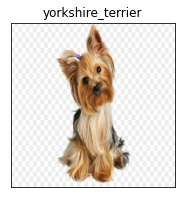

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)